## Ensemble learning

# vocal extraction using LSTM

TensorFlow version: 2.13.1
GPU available: []
Loading data...
Original MFCCs length: 9986, Labels length: 9986
Aligned MFCCs length: 9986, Labels length: 9986
X shape: (9986, 130, 13), y shape: (9986,)
Adjusted X shape: (9986, 40, 132)
X_train shape: (6990, 40, 132), X_val shape: (1498, 40, 132), X_test shape: (1498, 40, 132)
Building and training LSTM vocal classifier...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 40, 512)           796672    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 512)               1574912   
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
          

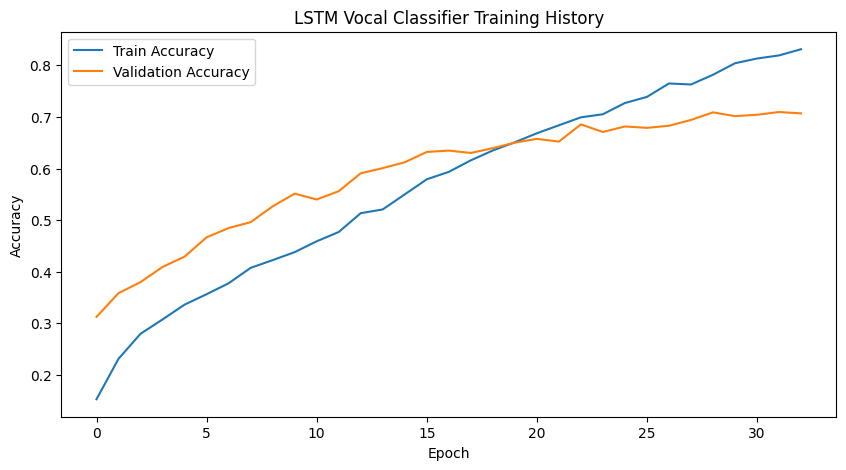

47/47 [==============================] - 6s 98ms/step


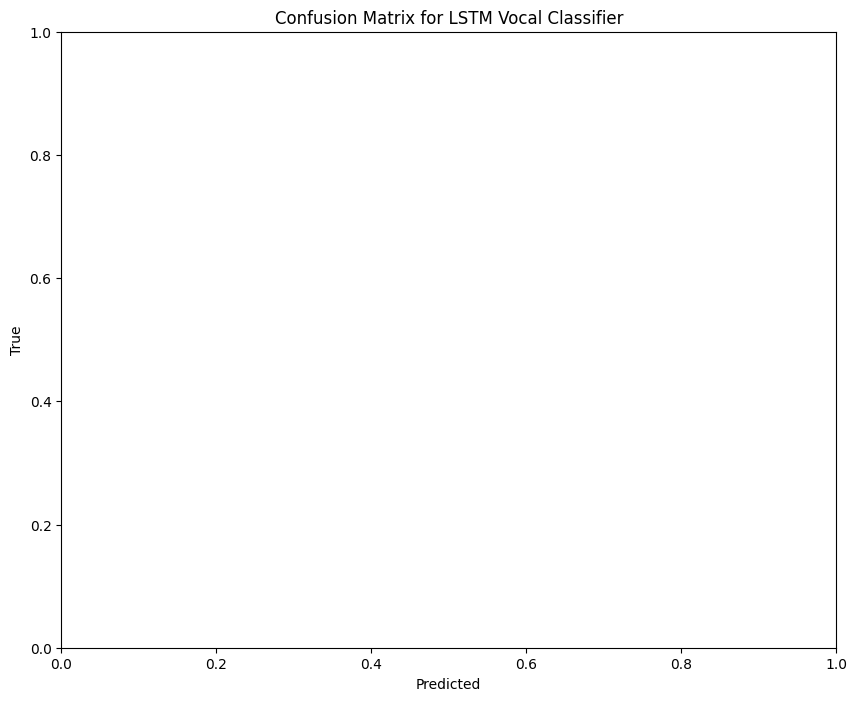

LSTM model saved to ../Data/lstm_vocal_classifier.keras


In [5]:
import tensorflow as tf
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import librosa
import os
from sklearn.metrics import confusion_matrix


# Verify TensorFlow and GPU
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Disable mixed precision for CPU compatibility
tf.keras.mixed_precision.set_global_policy('float32')

# Parameters
batch_size = 64
data_path = '../Data/data.json'  # Path to data.json
model_save_path = '../Data/lstm_vocal_classifier.keras'
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
num_classes = len(genres)
epochs = 250
learning_rate = 0.0001
sample_rate = 22050
hop_length = 512
n_mfcc = 40  # Paper uses 40 MFCCs
n_frames = 132  # Paper expects 132 frames for 3-second segments

# Load data
print("Loading data...")
with open(data_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract MFCCs and labels
mfccs = data['mfcc']
labels = data['genre_num']

# Validate and align data
print(f"Original MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")
min_length = min(len(mfccs), len(labels))
mfccs = mfccs[:min_length]
labels = labels[:min_length]
print(f"Aligned MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")

# Convert to NumPy arrays
X = np.array(mfccs)
y = np.array(labels)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Check for non-finite values
if not np.isfinite(X).all():
    print("Warning: Non-finite values in MFCCs, replacing with zeros")
    X = np.where(np.isfinite(X), X, 0.0)

# Handle MFCC shape mismatch
if X.shape[1:] == (130, 13):
    print(f"Warning: MFCC shape {X.shape[1:]} does not match expected (40, 132). Attempting to fix...")
    # Option 1: Pad MFCCs to (40, 132)
    if X.shape[1] > 40:
        X = X[:, :40, :]  # Truncate to 40 coefficients
    else:
        X = np.pad(X, ((0, 0), (0, 40 - X.shape[1]), (0, 0)), mode='constant')
    if X.shape[2] < 132:
        X = np.pad(X, ((0, 0), (0, 0), (0, 132 - X.shape[2])), mode='constant')
    print(f"Adjusted X shape: {X.shape}")
else:
    print(f"Unexpected MFCC shape {X.shape[1:]}. Please verify data.json or provide raw audio for re-extraction.")


# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

# Create tf.data datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Define LSTM model (from paper)
def build_lstm_vocal_classifier(input_shape=(40, 132), num_classes=10):
    model = Sequential([
        Bidirectional(LSTM(256, return_sequences=True), input_shape=input_shape),
        Bidirectional(LSTM(256)),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax', dtype='float32')
    ])
    return model

# Build and compile model
print("Building and training LSTM vocal classifier...")
lstm_model = build_lstm_vocal_classifier(input_shape=(40, 132))
lstm_model.compile(optimizer=Adam(learning_rate=learning_rate),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
lstm_model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train model
history = lstm_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Evaluate model
test_loss, test_accuracy = lstm_model.evaluate(test_dataset)
print(f"LSTM Vocal Classifier Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('LSTM Vocal Classifier Training History')
plt.show()

# Generate confusion matrix
y_pred = lstm_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for LSTM Vocal Classifier')
plt.show()

# Save model
lstm_model.save(model_save_path)
print(f"LSTM model saved to {model_save_path}")

TensorFlow version: 2.13.1
GPU available: []
Loading data...
Original MFCCs length: 9986, Labels length: 9986
Aligned MFCCs length: 9986, Labels length: 9986
X shape: (9986, 130, 13), y shape: (9986,)
Adjusting MFCCs for LSTM to (40, 132)...
LSTM X shape: (9986, 40, 132)
CRNN X shape: (9986, 130, 13, 1)
LSTM X_train shape: (6990, 40, 132), X_val shape: (1498, 40, 132), X_test shape: (1498, 40, 132)
CRNN X_train shape: (6990, 130, 13, 1), X_crnn_val shape: (1498, 130, 13, 1), X_crnn_test shape: (1498, 130, 13, 1)
Loading trained LSTM model...
24/24 [==============================] - 7s 197ms/step - loss: 1.0647 - accuracy: 0.6709
LSTM Vocal Classifier Test Loss: 1.0647, Accuracy: 0.6709
47/47 [==============================] - 10s 184ms/step


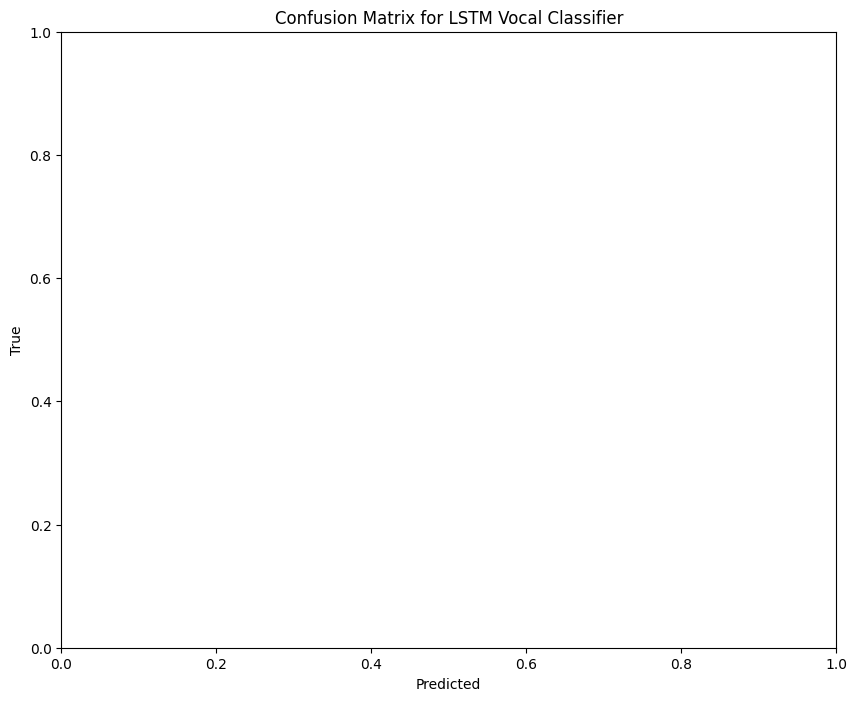

In [11]:
import tensorflow as tf
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix



# Verify TensorFlow and GPU
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Parameters
batch_size = 64
data_path = '../Data/data.json'
model_save_path = '../models/lstm_vocal_classifier.keras'
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
num_classes = len(genres)
epochs = 250
learning_rate = 0.0001
sample_rate = 22050
hop_length = 512
n_mfcc = 40
n_frames = 132

# Load data
print("Loading data...")
with open(data_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract MFCCs and labels
mfccs = data['mfcc']
labels = data['genre_num']

# Validate and align data
print(f"Original MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")
min_length = min(len(mfccs), len(labels))
mfccs = mfccs[:min_length]
labels = labels[:min_length]
print(f"Aligned MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")

# Convert to NumPy arrays
X = np.array(mfccs)
y = np.array(labels)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Check for non-finite values
if not np.isfinite(X).all():
    print("Warning: Non-finite values in MFCCs, replacing with zeros")
    X = np.where(np.isfinite(X), X, 0.0)

# Prepare MFCCs for LSTM (pad to (40, 132))
X_lstm = X.copy()
if X_lstm.shape[1:] == (130, 13):
    print(f"Adjusting MFCCs for LSTM to (40, 132)...")
    X_lstm = X_lstm[:, :40, :]  # Truncate to 40 coefficients
    X_lstm = np.pad(X_lstm, ((0, 0), (0, 0), (0, 132 - X_lstm.shape[2])), mode='constant')
    print(f"LSTM X shape: {X_lstm.shape}")
elif X_lstm.shape[1:] != (40, 132):
    print(f"Warning: LSTM input shape is {X_lstm.shape[1:]}, expected (40, 132). Model loading might fail.")


# Prepare MFCCs for CRNN (keep original (130, 13))
X_crnn = X[..., np.newaxis]  # Add channel dimension
print(f"CRNN X shape: {X_crnn.shape}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-validation-test split
X_lstm_train, X_lstm_temp, y_train, y_temp = train_test_split(X_lstm, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
X_lstm_val, X_lstm_test, y_val, y_test = train_test_split(X_lstm_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
X_crnn_train, X_crnn_temp = train_test_split(X_crnn, test_size=0.3, random_state=42)
X_crnn_val, X_crnn_test = train_test_split(X_crnn_temp, test_size=0.5, random_state=42)
print(f"LSTM X_train shape: {X_lstm_train.shape}, X_val shape: {X_lstm_val.shape}, X_test shape: {X_lstm_test.shape}")
print(f"CRNN X_train shape: {X_crnn_train.shape}, X_crnn_val shape: {X_crnn_val.shape}, X_crnn_test shape: {X_crnn_test.shape}")

# Create tf.data datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_lstm_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_lstm_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_lstm_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
crnn_test_dataset = tf.data.Dataset.from_tensor_slices((X_crnn_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)


# Define LSTM model (This function is here for reference, not used for loading)
def build_lstm_vocal_classifier(input_shape=(40, 132), num_classes=10):
    model = Sequential([
        Bidirectional(LSTM(256, return_sequences=True), input_shape=input_shape),
        Bidirectional(LSTM(256)),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax') # Removed dtype='float32' here as it's not needed for Sequential API's output layer
    ])
    return model

# Load and evaluate LSTM model (already trained)
print("Loading trained LSTM model...")
# Attempt to load the model
try:
    lstm_model = tf.keras.models.load_model(model_save_path)
    lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(test_dataset)
    print(f"LSTM Vocal Classifier Test Loss: {lstm_test_loss:.4f}, Accuracy: {lstm_test_accuracy:.4f}")

    # Generate LSTM confusion matrix
    y_pred_lstm = lstm_model.predict(X_lstm_test)
    y_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)
    cm_lstm = confusion_matrix(y_test, y_pred_lstm_classes)
    plt.figure(figsize=(10, 8))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix for LSTM Vocal Classifier')
    plt.show()

except Exception as e:
    print(f"Error loading or evaluating LSTM model: {e}")
    print("This might be due to a version mismatch between Keras versions used for saving and loading.")
    print("Consider retraining the model with the current Keras version or inspecting the saved model file structure.")

# Accompainment

In [ ]:
import tensorflow as tf
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import librosa
import os
from sklearn.metrics import confusion_matrix



# Verify TensorFlow and GPU
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Parameters
batch_size = 64
data_path = '../Data/data.json'
cnn_model_save_path = '../models/cnn_accompaniment_classifier.keras'
crnn_model_path = '../models/crnn.keras'
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
num_classes = len(genres)
epochs = 250
learning_rate = 0.0001
sample_rate = 22050
hop_length = 512
n_mfcc = 40
n_frames = 132

# Load data
print("Loading data...")
with open(data_path, 'r', encoding='utf-8') as f:
    # Changed fused() to json.load(f)
    data = json.load(f)

# Extract MFCCs and labels
mfccs = data['mfcc']
labels = data['genre_num']

# Validate and align data
# Corrected variable name mm_ccs to mfccs
print(f"Original MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")
min_length = min(len(mfccs), len(labels))
mfccs = mfccs[:min_length]
labels = labels[:min_length]
print(f"Aligned MFCCs length: {len(mfccs)}, Labels length: {len(labels)}")

# Convert to NumPy arrays
X = np.array(mfccs)
y = np.array(labels)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Check for non-finite values
if not np.isfinite(X).all():
    print("Warning: Non-finite values in MFCCs, replacing with zeros")
    X = np.where(np.isfinite(X), X, 0.0)

# Prepare MFCCs for CNN (pad to (40, 132, 1))
X_cnn = X.copy()
if X_cnn.shape[1:] == (130, 13):
    print(f"Adjusting MFCCs for CNN to (40, 132)...")
    X_cnn = X_cnn[:, :40, :]  # Truncate to 40 coefficients
    X_cnn = np.pad(X_cnn, ((0, 0), (0, 0), (0, 132 - X_cnn.shape[2])), mode='constant')
    X_cnn = X_cnn[..., np.newaxis]  # Add channel dimension
    print(f"CNN X shape: {X_cnn.shape}")

# Prepare MFCCs for CRNN (keep original (130, 13, 1))
X_crnn = X[..., np.newaxis]
print(f"CRNN X shape: {X_crnn.shape}")


# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-validation-test split
X_cnn_train, X_cnn_temp, y_train, y_temp = train_test_split(X_cnn, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
X_cnn_val, X_cnn_test, y_val, y_test = train_test_split(X_cnn_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
X_crnn_train, X_crnn_temp = train_test_split(X_crnn, test_size=0.3, random_state=42)
X_crnn_val, X_crnn_test = train_test_split(X_crnn_temp, test_size=0.5, random_state=42)
print(f"CNN X_train shape: {X_cnn_train.shape}, X_val shape: {X_cnn_val.shape}, X_test shape: {X_cnn_test.shape}")
print(f"CRNN X_train shape: {X_crnn_train.shape}, X_val shape: {X_crnn_val.shape}, X_crnn_test shape: {X_crnn_test.shape}")

# Create tf.data datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_cnn_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_cnn_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_cnn_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
crnn_test_dataset = tf.data.Dataset.from_tensor_slices((X_crnn_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Define CNN model (from paper)
def build_cnn_accompaniment_classifier(input_shape=(40, 132, 1), num_classes=10):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Build and compile CNN model
print("Building and training CNN accompaniment classifier...")
cnn_model = build_cnn_accompaniment_classifier()
cnn_model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
cnn_model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train CNN model
history = cnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Evaluate CNN model
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_dataset)
print(f"CNN Accompaniment Classifier Test Loss: {cnn_test_loss:.4f}, Accuracy: {cnn_test_accuracy:.4f}")

# Generate CNN confusion matrix
y_pred_cnn = cnn_model.predict(X_cnn_test)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
cm_cnn = confusion_matrix(y_test, y_pred_cnn_classes)
plt.figure(figsize=(10, 8))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CNN Accompaniment Classifier')
plt.show()

# Save CNN model
cnn_model.save(cnn_model_save_path)
print(f"CNN model saved to {cnn_model_save_path}")

# Evaluate CRNN model
if os.path.exists(crnn_model_path):
    print("Loading and evaluating pre-trained CRNN model...")
    try:
        crnn_model = tf.keras.models.load_model(crnn_model_path)
        crnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
        crnn_test_loss, crnn_test_accuracy = crnn_model.evaluate(crnn_test_dataset)
        print(f"CRNN Test Loss: {crnn_test_loss:.4f}, Accuracy: {crnn_test_accuracy:.4f}")

        # Generate CRNN confusion matrix
        y_pred_crnn = crnn_model.predict(X_crnn_test)
        y_pred_crnn_classes = np.argmax(y_pred_crnn, axis=1)
        cm_crnn = confusion_matrix(y_test, y_pred_crnn_classes)
        plt.figure(figsize=(10, 8))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for CRNN Accompaniment Classifier')
        plt.show()
    except Exception as e:
        print(f"Error evaluating CRNN model: {e}")
else:
    print("CRNN model not found at", crnn_model_path)

TensorFlow version: 2.13.1
GPU available: []
Loading data...
Original MFCCs length: 9986, Labels length: 9986
Aligned MFCCs length: 9986, Labels length: 9986
X shape: (9986, 130, 13), y shape: (9986,)
Adjusting MFCCs for CNN to (40, 132)...
CNN X shape: (9986, 40, 132, 1)
CRNN X shape: (9986, 130, 13, 1)
CNN X_train shape: (6990, 40, 132, 1), X_val shape: (1498, 40, 132, 1), X_test shape: (1498, 40, 132, 1)
CRNN X_train shape: (6990, 130, 13, 1), X_val shape: (1498, 130, 13, 1), X_crnn_test shape: (1498, 130, 13, 1)
Building and training CNN accompaniment classifier...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 132, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 20, 66, 64)        0         
 D)                                                              
      

NameError: name 'sns' is not defined

<Figure size 1000x800 with 0 Axes>